In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import dlib

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# 1. Preprocessing and EDA (Exploratory Data Analysis)

In [3]:
def load_dataset(dataset_path):
    images = []
    labels = []
    
    for label in os.listdir(dataset_path):
        for file_name in os.listdir(os.path.join(dataset_path, label)):
            img = cv2.imread(os.path.join(dataset_path, label, file_name), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(label)
    
    return images, labels

In [4]:
train_dir = "../data/fer-2013-data/train"
for dirpath,dirname,filenames in os.walk(train_dir):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dirpath[22:]}")

There are 7 directories and 0 images in train
There are 0 directories and 3995 images in train\angry
There are 0 directories and 436 images in train\disgust
There are 0 directories and 4097 images in train\fear
There are 0 directories and 7215 images in train\happy
There are 0 directories and 4965 images in train\neutral
There are 0 directories and 4830 images in train\sad
There are 0 directories and 3171 images in train\surprise


In [5]:
test_dir = "../data/fer-2013-data/test"
for dirpath,dirname,filenames in os.walk(test_dir):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dirpath[22:]}")

There are 7 directories and 0 images in test
There are 0 directories and 958 images in test\angry
There are 0 directories and 111 images in test\disgust
There are 0 directories and 1024 images in test\fear
There are 0 directories and 1774 images in test\happy
There are 0 directories and 1233 images in test\neutral
There are 0 directories and 1247 images in test\sad
There are 0 directories and 831 images in test\surprise


In [6]:
data_gen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2)
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)
validation_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


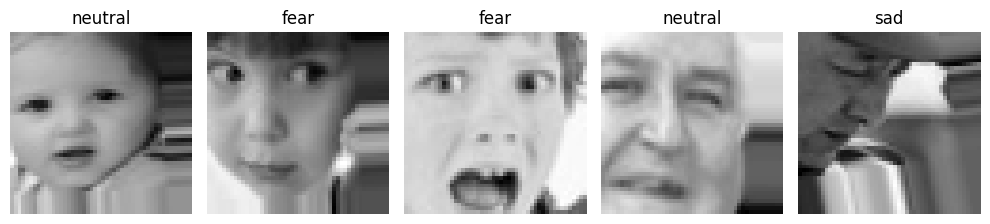

In [9]:
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())

def plot_example_images(images_arr, labels_arr, label_map):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels_arr, axes):
        class_label = label_map[np.argmax(label)]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(class_label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(train_generator)
plot_example_images(images[:5], labels[:5], label_map)

In [7]:
# this function will gives us singularity for image showing
# using matplotlib for displaying
def show_image_as_plot(image_path=None, image=None):
    if image_path:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    #image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    #plt.imshow(image_rgb)
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    plt.show()

# 2. Traditional Image Processing/Enhancement

In [8]:
# Image enhancement for low level vision: image inpainting
# Image Inpainting is a task of reconstructing missing regions in an image.
def image_inpainting(image_path=None, image=None, inpaint_radius=3, block_size=9, C=7):
    if image_path:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise ValueError("The image could not be loaded.")

    mask = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    inpainted_image = cv2.inpaint(image, mask, inpaint_radius, cv2.INPAINT_TELEA)
    
    return inpainted_image

# Image enhancement for low level vision: image resizing
def image_resizing(image_path=None, image=None, dimensions=(48,48), interpolation=cv2.INTER_LINEAR):
    # image: the image to resize.
    # dimensions: the new image dimensions as a tuple (width, height).
    # interpolation: method of interpolation.
    if image_path:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
    if image is None:
        raise ValueError("The image could not be loaded.")
    
    resized_image = cv2.resize(image, dimensions, interpolation=interpolation)
    return resized_image

# Histogram equalization to enhance features of images
def histogram_equalization(image_path=None, image=None):
    if image_path:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise ValueError("The image could not be loaded.")
    
    equalized_image = cv2.equalizeHist(image)
    return equalized_image

# Reduce noise by median blur
def reduce_noise_median(image_path=None, image=None):
    if image_path:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
    if image is None:
        raise ValueError("The image could not be loaded.")
    
    denoised_image = cv2.medianBlur(image, 3)
    return denoised_image

# Reduce noise by gaussian filter
def reduce_noise_gaussian(image_path=None, image=None):
    if image_path:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise ValueError("The image could not be loaded.")
    
    denoised_image = cv2.GaussianBlur(image, (3, 3), 0)
    return denoised_image

# Reduce noise: firstly, gaussian filter secondly, median blur
def smooth_image_first_gaussian(image_path=None, image=None):
    if image_path:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
    if image is None:
        raise ValueError("The image could not be loaded.")
    
    image = reduce_noise_gaussian(image=image)
    image = reduce_noise_median(image=image)
    return image

# Reduce noise: firstly, median blur secondly, Gaussian filter
def smooth_image_first_median(image_path=None, image=None):
    if image_path:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
    if image is None:
        raise ValueError("The image could not be loaded.")
    
    image = reduce_noise_median(image=image)
    image = reduce_noise_gaussian(image=image)
    return image

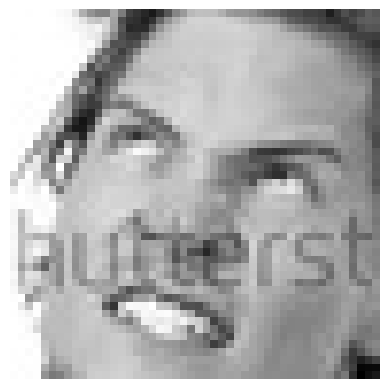

In [9]:
# this is an example image to show our enhancements on images
#improvable_image_path = "../data/fer-2013-data/train/angry/Training_2861857.jpg"
improvable_image_path = "../data/fer-2013-data/train/angry/Training_6640570.jpg"
show_image_as_plot(image_path=improvable_image_path)

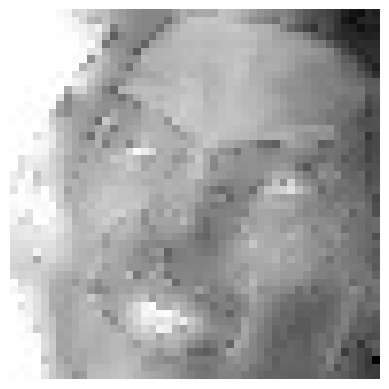

In [10]:
inpainted_image = image_inpainting(image_path=improvable_image_path)
show_image_as_plot(image=inpainted_image)

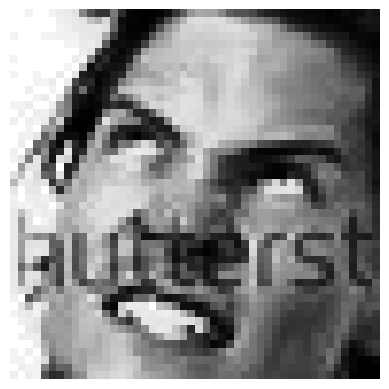

In [11]:
hist_equilazed_image = histogram_equalization(image_path=improvable_image_path)
show_image_as_plot(image=hist_equilazed_image)

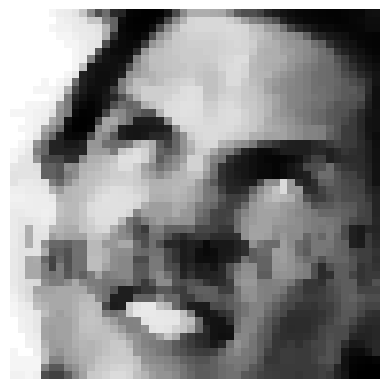

In [12]:
median_blur_image = reduce_noise_median(image_path=improvable_image_path)
first_median_then_hist_image = histogram_equalization(image=median_blur_image)
show_image_as_plot(image=first_median_then_hist_image)

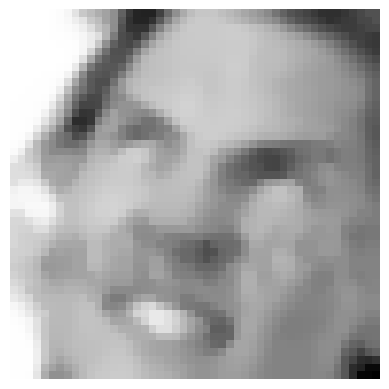

In [13]:
first_gaussian_then_median_image = smooth_image_first_gaussian(image_path=improvable_image_path)
show_image_as_plot(image=first_gaussian_then_median_image)

# 3. Feature Matching

In [14]:
def sift_creator(image_path=None, image=None):
    if image_path:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise ValueError("The image could not be loaded.")
    
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    img_sift = cv2.drawKeypoints(image, keypoints, None)

    return img_sift, descriptors

In [15]:
def extract_features(images):
    descriptors_list = []

    for img in images:
        _, descriptors = sift_creator(image=img)
        if descriptors is not None:
            descriptors_list.append(descriptors.mean(axis=0))
        else:
            descriptors_list.append(np.zeros(128))
    
    return np.array(descriptors_list)

In [16]:
# shape_predictor_68_face_landmarks.dat pretrained keypoint extraction model
# datFile =  "../data/shape_predictor_68_face_landmarks.dat"
# detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor(datFile)

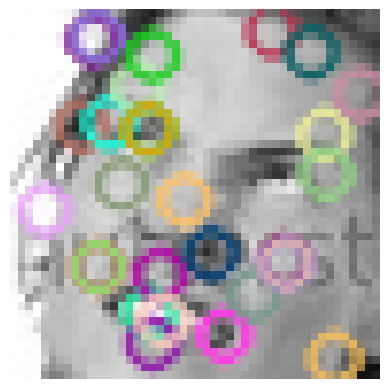

In [17]:
sift_img, _= sift_creator(image_path=improvable_image_path)
show_image_as_plot(image=sift_img)

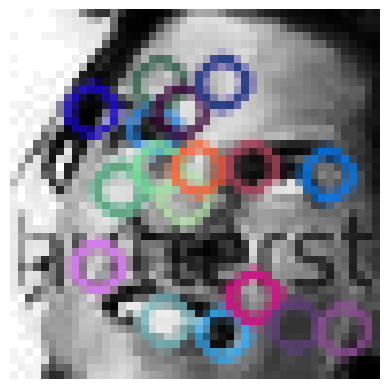

In [18]:
sift_img, _ = sift_creator(image=hist_equilazed_image)
show_image_as_plot(image=sift_img)

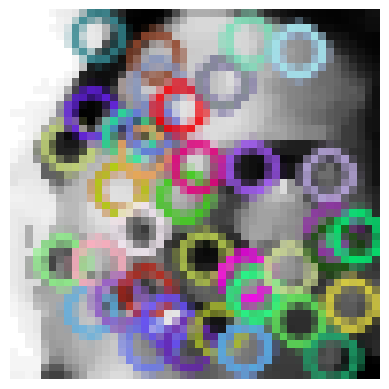

In [19]:
sift_img, _ = sift_creator(image=first_median_then_hist_image)
show_image_as_plot(image=sift_img)

# 4. ML Models

In [20]:
images_train, labels_train = load_dataset(train_dir)
features_train = extract_features(images_train)

images_test, labels_test = load_dataset(test_dir)
features_test = extract_features(images_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(features_train)
y_train = np.array(labels_train)
X_test = scaler.transform(features_test)
y_test = np.array(labels_test)

In [21]:
def svm(X_train, y_train, X_test, y_test):
    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train, y_train)
    svm_predictions = svm_model.predict(X_test)
    
    svm_accuracy = accuracy_score(y_test, svm_predictions)
    print(f'SVM Accuracy: {svm_accuracy}')

def knn(X_train, y_train, X_test, y_test):
    knn_model = KNeighborsClassifier(n_neighbors=3)
    knn_model.fit(X_train, y_train)
    knn_predictions = knn_model.predict(X_test)
    
    knn_accuracy = accuracy_score(y_test, knn_predictions)
    print(f'kNN Accuracy: {knn_accuracy}')
    
def random_forest(X_train, y_train, X_test, y_test):
    rf_model = RandomForestClassifier(n_estimators=100)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    print(f'Random Forest Accuracy: {rf_accuracy}')

In [23]:
svm(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

SVM Accuracy: 0.2811368069100028


In [ ]:
df_train = pd.DataFrame({'X_train':X_train,'y_train' :y_train})
ten, soluong = np.unique(df_test.y_test,return_counts=True)
plt.bar(name_train, frequence_train)
plt.bar(ten, soluong, bottom=frequence_train, color='r')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')